In [1]:
# hide
%load_ext autoreload
%autoreload 2

In [2]:
# default_exp download

# Download



> Functionality to easily download data to your environment.

## Overview

`numerblox` currently provides the following Downloaders:
1. `NumeraiClassicDownloader`
2. `KaggleDownloader`
3. `PandasDataReader`
4. `FinnhubDownloader`
5. `EODDownloader`

This notebook also implements a general base class for IO (`BaseIO`) that handles directory logic and integration with GCS (Google Cloud Storage).

The last section at the bottom explains how you can implement your own Downloader in `numerblox`.

In [3]:
# hide
from nbdev.showdoc import *

In [4]:
# export
import os
import glob
import json
import shutil
import finnhub
import concurrent
import pandas as pd
from tqdm.auto import tqdm
from rich.tree import Tree
from functools import partial
from numerapi import NumerAPI
import pandas_datareader as web
import matplotlib.pyplot as plt
from google.cloud import storage
from rich.console import Console
from eod import EodHistoricalData
from typeguard import typechecked
from datetime import datetime as dt
from pathlib import Path, PosixPath
from abc import ABC, abstractmethod
from rich import print as rich_print
from concurrent.futures import ThreadPoolExecutor
from dateutil.relativedelta import relativedelta
from pandas_datareader._utils import RemoteDataError

from numerblox.numerframe import NumerFrame

## 0. BaseIO

There are common methods needed for `Downloaders` and `Submittors`. `BaseIO` implements this functionality and allows us to make abstract base classes. Namely, `BaseDownloader` and `BaseSubmitter` (implemented in `submission` section).

In [5]:
# export
@typechecked
class BaseIO(ABC):
    """
    Basic functionality for IO (downloading and uploading).

    :param directory_path: Base folder for IO. Will be created if it does not exist.
    """
    def __init__(self, directory_path: str):
        self.dir = Path(directory_path)
        self._create_directory()

    def remove_base_directory(self):
        """Remove directory with all contents."""
        abs_path = self.dir.resolve()
        rich_print(
            f":warning: [red]Deleting directory for '{self.__class__.__name__}[/red]' :warning:\nPath: '{abs_path}'"
        )
        shutil.rmtree(abs_path)

    def download_file_from_gcs(self, bucket_name: str, gcs_path: str):
        """
        Get file from GCS bucket and download to local directory.
        :param gcs_path: Path to file on GCS bucket.
        """
        blob_path = str(self.dir.resolve())
        blob = self._get_gcs_blob(bucket_name=bucket_name, blob_path=blob_path)
        blob.download_to_filename(gcs_path)
        rich_print(
            f":cloud: :page_facing_up: Downloaded GCS object '{gcs_path}' from bucket '{blob.bucket.id}' to local directory '{blob_path}'. :page_facing_up: :cloud:"
        )

    def upload_file_to_gcs(self, bucket_name: str, gcs_path: str, local_path: str):
        """
        Upload file to some GCS bucket.
        :param gcs_path: Path to file on GCS bucket.
        """
        blob = self._get_gcs_blob(bucket_name=bucket_name, blob_path=gcs_path)
        blob.upload_from_filename(local_path)
        rich_print(
            f":cloud: :page_facing_up: Local file '{local_path}' uploaded to '{gcs_path}' in bucket {blob.bucket.id}:page_facing_up: :cloud:"
        )

    def download_directory_from_gcs(self, bucket_name: str, gcs_path: str):
        """
        Copy full directory from GCS bucket to local environment.
        :param gcs_path: Name of directory on GCS bucket.
        """
        blob_path = str(self.dir.resolve())
        blob = self._get_gcs_blob(bucket_name=bucket_name, blob_path=blob_path)
        for gcs_file in glob.glob(gcs_path + "/**", recursive=True):
            if os.path.isfile(gcs_file):
                blob.download_to_filename(blob_path)
        rich_print(
            f":cloud: :folder: Directory '{gcs_path}' from bucket '{blob.bucket.id}' downloaded to '{blob_path}' :folder: :cloud:"
        )

    def upload_directory_to_gcs(self, bucket_name: str, gcs_path: str):
        """
        Upload full base directory to GCS bucket.
        :param gcs_path: Name of directory on GCS bucket.
        """
        blob = self._get_gcs_blob(bucket_name=bucket_name, blob_path=gcs_path)
        for local_path in glob.glob(str(self.dir) + "/**", recursive=True):
            if os.path.isfile(local_path):
                blob.upload_from_filename(local_path)
        rich_print(
            f":cloud: :folder: Directory '{self.dir}' uploaded to '{gcs_path}' in bucket {blob.bucket.id} :folder: :cloud:"
        )

    def _get_gcs_blob(self, bucket_name: str, blob_path: str) -> storage.Blob:
        """ Create blob that interacts with Google Cloud Storage (GCS). """
        client = storage.Client()
        # https://console.cloud.google.com/storage/browser/[bucket_name]
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_path)
        return blob

    def _append_folder(self, folder: str) -> Path:
        """
        Return base directory Path object appended with 'folder'.
        Create directory if it does not exist.
        """
        dir = Path(self.dir / folder)
        dir.mkdir(parents=True, exist_ok=True)
        return dir

    def _create_directory(self):
        """ Create base directory if it does not exist. """
        if not self.dir.is_dir():
            rich_print(
                f"No existing directory found at '[blue]{self.dir}[/blue]'. Creating directory..."
            )
            self.dir.mkdir(parents=True, exist_ok=True)

    @property
    def get_all_files(self) -> list:
        """ Return all paths of contents in directory. """
        return list(self.dir.iterdir())

    @property
    def is_empty(self) -> bool:
        """ Check if directory is empty. """
        return not bool(self.get_all_files)

## 1. BaseDownloader

`BaseDownloader` is an object which implements logic common to all downloaders.

To implement a new Downloader, you should inherit from `BaseDownloader` and be sure to implement at least methods for `.download_training_data` and `.download_inference_data`.

In [6]:
# export
@typechecked
class BaseDownloader(BaseIO):
    """
    Abstract base class for downloaders.

    :param directory_path: Base folder to download files to.
    """
    def __init__(self, directory_path: str):
        super().__init__(directory_path=directory_path)

    @abstractmethod
    def download_training_data(self, *args, **kwargs):
        """ Download all necessary files needed for training. """
        ...

    @abstractmethod
    def download_inference_data(self, *args, **kwargs):
        """ Download minimal amount of files needed for weekly inference. """
        ...

    @staticmethod
    def _load_json(file_path: str, verbose=False, *args, **kwargs) -> dict:
        """ Load JSON from file and return as dictionary. """
        with open(Path(file_path)) as json_file:
            json_data = json.load(json_file, *args, **kwargs)
        if verbose:
            rich_print(json_data)
        return json_data

    def _default_save_path(self, start: dt, end: dt, backend: str):
        """ Save to downloader directory indicating backend, start date and end date as parquet file. """
        return f"{self.dir}/{backend}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.parquet"

    def __call__(self, *args, **kwargs):
        """
        The most common use case will be to get weekly inference data. So calling the class itself returns inference data.
        """
        self.download_inference_data(*args, **kwargs)

## 2. Numerai Classic

In [7]:
# export
class NumeraiClassicDownloader(BaseDownloader):
    """
    WARNING: Versions 1 and 2 (legacy data) are deprecated. Only supporting version 3+.

    Downloading from NumerAPI for Numerai Classic data. \n
    :param directory_path: Base folder to download files to. \n
    All *args, **kwargs will be passed to NumerAPI initialization.
    """
    def __init__(self, directory_path: str, *args, **kwargs):
        super().__init__(directory_path=directory_path)
        self.napi = NumerAPI(*args, **kwargs)
        self.current_round = self.napi.get_current_round()
        # NumerAPI filenames corresponding to version, class and data type
        self.version_mapping = {"3": {
            "train": {
                "int8": [
                    "v3/numerai_training_data_int8.parquet",
                    "v3/numerai_validation_data_int8.parquet"
                ],
                "float": [
                    "v3/numerai_training_data.parquet",
                    "v3/numerai_validation_data.parquet"
                ]
            },
            "inference": {
                "int8": ["v3/numerai_tournament_data_int8.parquet"],
                "float": ["v3/numerai_tournament_data.parquet"]
            },
            "live": {
                "int8": ["v3/numerai_live_data_int8.parquet"],
                "float": ["v3/numerai_live_data.parquet"]
            },
            "example": [
                "v3/example_predictions.parquet",
                "v3/example_validation_predictions.parquet"
            ]
        },
            "4": {
                "train": {
                    "int8": [
                        "v4/train_int8.parquet",
                        "v4/validation_int8.parquet"
                    ],
                    "float": [
                        "v4/train.parquet",
                        "v4/validation.parquet"
                    ]
                },
                "inference": {
                    "int8": ["v4/live_int8.parquet"],
                    "float": ["v4/live.parquet"]
                },
                "live": {
                    "int8": ["v4/live_int8.parquet"],
                    "float": ["v4/live.parquet"]
                },
                "example": [
                    "v4/live_example_preds.parquet",
                    "v4/validation_example_preds.parquet"
                ]
            }
        }

    def download_training_data(
        self, subfolder: str = "", version: int = 4, int8: bool = False
    ):
        """
        Get Numerai classic training and validation data.
        :param subfolder: Specify folder to create folder within base directory root.
        Saves in base directory root by default.
        :param version: Numerai dataset version (3=1050+ features dataset (parquet))
        :param int8: Integer version of data
        """
        data_type = "int8" if int8 else "float"
        train_val_files = self._get_version_mapping(version)["train"][data_type]
        for file in train_val_files:
            dest_path = self.__get_dest_path(subfolder, file)
            self.download_single_dataset(
                filename=file,
                dest_path=dest_path
            )

    def download_inference_data(
        self,
        subfolder: str = "",
        version: int = 4,
        int8: bool = False,
        round_num: int = None,
    ):
        """
        Get Numerai classic inference (tournament) data.
        If only minimal live data is needed, consider .download_live_data.
        :param subfolder: Specify folder to create folder within base directory root.
        Saves in base directory root by default.
        :param version: Numerai dataset version (2=super massive dataset (parquet))
        :param int8: Integer version of data
        :param round_num: Numerai tournament round number. Downloads latest round by default.
        """
        data_type = "int8" if int8 else "float"
        inference_files = self._get_version_mapping(version)["inference"][data_type]
        for file in inference_files:
            dest_path = self.__get_dest_path(subfolder, file)
            self.download_single_dataset(
                filename=file,
                dest_path=dest_path,
                round_num=round_num
            )

    def download_single_dataset(
        self, filename: str, dest_path: str, round_num: int = None
    ):
        """
        Download one of the available datasets through NumerAPI.

        :param filename: Name as listed in NumerAPI (Check NumerAPI().list_datasets() for full overview)
        :param dest_path: Full path where file will be saved.
        :param round_num: Numerai tournament round number. Downloads latest round by default.
        """
        rich_print(
            f":file_folder: [green]Downloading[/green] '{filename}' :file_folder:"
        )
        self.napi.download_dataset(
            filename=filename,
            dest_path=dest_path,
            round_num=round_num
        )

    def download_live_data(
            self,
            subfolder: str = "",
            version: int = 4,
            int8: bool = False,
            round_num: int = None
    ):
        """
        Download all live data in specified folder for given version (i.e. minimal data needed for inference).

        :param subfolder: Specify folder to create folder within directory root.
        Saves in directory root by default.
        :param version: Numerai dataset version (2=super massive dataset (parquet))
        :param int8: Integer version of data
        :param round_num: Numerai tournament round number. Downloads latest round by default.
        """
        data_type = "int8" if int8 else "float"
        live_files = self._get_version_mapping(version)["live"][data_type]
        for file in live_files:
            dest_path = self.__get_dest_path(subfolder, file)
            self.download_single_dataset(
                filename=file,
                dest_path=dest_path,
                round_num=round_num
            )

    def download_example_data(
        self, subfolder: str = "", version: int = 4, round_num: int = None
    ):
        """
        Download all example prediction data in specified folder for given version.

        :param subfolder: Specify folder to create folder within base directory root.
        Saves in base directory root by default.
        :param version: Numerai dataset version (2=super massive dataset (parquet))
        :param round_num: Numerai tournament round number. Downloads latest round by default.
        """
        example_files = self._get_version_mapping(version)["example"]
        for file in example_files:
            dest_path = self.__get_dest_path(subfolder, file)
            self.download_single_dataset(
                filename=file,
                dest_path=dest_path,
                round_num=round_num
            )

    def get_classic_features(self, subfolder: str = "", filename="v4/features.json", *args, **kwargs) -> dict:
        """
        Download feature overview (stats and feature sets) through NumerAPI and load as dict.
        :param subfolder: Specify folder to create folder within base directory root.
        Saves in base directory root by default.
        :param filename: name for feature overview.
        Currently defined as 'features.json' in NumerAPI and used as default.
        *args, **kwargs will be passed to the JSON loader.
        """
        dest_path = self.__get_dest_path(subfolder, filename)
        self.download_single_dataset(filename=filename,
                                     dest_path=dest_path)
        json_data = self._load_json(dest_path, *args, **kwargs)
        return json_data

    def _get_version_mapping(self, version: int) -> dict:
        """ Check if data version is supported and return file mapping for version. """
        try:
            mapping_dictionary = self.version_mapping[str(version)]
        except KeyError:
            raise NotImplementedError(
                f"Version '{version}' is not available. Available versions are {list(self.version_mapping.keys())}"
            )
        return mapping_dictionary

    def __get_dest_path(self, subfolder: str, filename: str) -> str:
        """ Prepare destination path for downloading. """
        dir = self._append_folder(subfolder)
        dest_path = str(dir.joinpath(filename.split("/")[-1]))
        return dest_path

In [8]:
# hide
# slow
test_dir_classic = "test_numclassic_general"
numer_classic_downloader = NumeraiClassicDownloader(test_dir_classic)

# Test building class
assert isinstance(numer_classic_downloader.dir, PosixPath)
assert numer_classic_downloader.dir.is_dir()

# Test is_empty
(numer_classic_downloader.dir / "test.txt").write_text("test")
rich_print(f"Directory contents:\n{numer_classic_downloader.get_all_files}")
assert not numer_classic_downloader.is_empty

# Downloading example data
numer_classic_downloader.download_example_data("test/", version=3, round_num=310)

# Features
feature_stats_test = numer_classic_downloader.get_classic_features()
assert isinstance(feature_stats_test, dict)
assert len(feature_stats_test["feature_sets"]["medium"]) == 472

# Remove contents
numer_classic_downloader.remove_base_directory()
assert not os.path.exists(test_dir_classic)

No existing directory found at 'test_numclassic_general'. Creating directory...

Directory contents:
[Path('test_numclassic_general/test.txt')]

📁 Downloading 'v3/example_predictions.parquet' 📁

2022-05-25 13:33:02,670 INFO numerapi.utils: starting download
test_numclassic_general/test/example_predictions.parquet: 33.5MB [00:05, 5.65MB/s]                            


📁 Downloading 'v3/example_validation_predictions.parquet' 📁

2022-05-25 13:33:10,263 INFO numerapi.utils: starting download
test_numclassic_general/test/example_validation_predictions.parquet: 13.0MB [00:02, 4.94MB/s]                            


📁 Downloading 'v4/features.json' 📁

2022-05-25 13:33:14,502 INFO numerapi.utils: starting download
test_numclassic_general/features.json: 562kB [00:00, 914kB/s]                            


⚠ Deleting directory for 'NumeraiClassicDownloader' ⚠
Path: 
'/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/test_numclassic_general'

### 2.1. Example usage

This section will explain how to quickly get started with `NumeraiClassicDownloader`.

The more advanced use case of working with GCS (Google Cloud Storage) is discussed in `edu_nbs/google_cloud_storage.ipynb`.

#### 2.1.1. Training data

Training + validation data for Numerai Classic can be downloaded with effectively 2 lines of code.
Feature stats and overview can be downloaded with `.get_classic_features()`.

In [9]:
# slow
# Initialization
train_base_directory = "test_numclassic_train"
numer_classic_downloader = NumeraiClassicDownloader(train_base_directory)

# Uncomment line below to download training and validation data
# numer_classic_downloader.download_training_data("train_val", int8=False)

# Get feature overview (dict)
numer_classic_downloader.get_classic_features()

# Remove contents (To clean up environment)
numer_classic_downloader.remove_base_directory()

No existing directory found at 'test_numclassic_train'. Creating directory...

📁 Downloading 'v4/features.json' 📁

2022-05-25 13:33:17,118 INFO numerapi.utils: starting download
test_numclassic_train/features.json: 562kB [00:00, 915kB/s]                            


⚠ Deleting directory for 'NumeraiClassicDownloader' ⚠
Path: 
'/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/test_numclassic_train'

__For the training example the directory structure will be:__

In [10]:
# hide_input
console = Console(record=True, width=100)

tree = Tree(
    f":file_folder: {train_base_directory} (base_directory)",
    guide_style="bold bright_black",
)
folder_tree = tree.add(":page_facing_up: features.json")
train_val_tree = tree.add(":file_folder: train_val")
train_val_tree.add(":page_facing_up: numerai_training_data.parquet")
train_val_tree.add(":page_facing_up: numerai_validation_data.parquet")

console.print(tree)

📁 test_numclassic_train (base_directory)                                                           
┣━━ 📄 features.json                                                                                
┗━━ 📁 train_val                                                                                    
    ┣━━ 📄 numerai_training_data.parquet                                                            
    ┗━━ 📄 numerai_validation_data.parquet

#### 2.1.2. Inference data

Inference data for the most recent round of Numerai Classic can be downloaded with effectively 2 lines of code.
It can also easily be deleted after you are done with inference by calling `.remove_base_directory`.

In [11]:
# slow
# Initialization
inference_base_dir = "test_numclassic_inference"
numer_classic_downloader = NumeraiClassicDownloader(directory_path=inference_base_dir)

# Download tournament (inference) data
numer_classic_downloader.download_inference_data("inference", version=4, int8=True)

# Remove folder when done with inference
numer_classic_downloader.remove_base_directory()

No existing directory found at 'test_numclassic_inference'. Creating directory...

📁 Downloading 'v4/live_int8.parquet' 📁

2022-05-25 13:33:19,663 INFO numerapi.utils: starting download
test_numclassic_inference/inference/live_int8.parquet: 3.51MB [00:01, 2.72MB/s]                            


⚠ Deleting directory for 'NumeraiClassicDownloader' ⚠
Path: '/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/test_numclassic_in
ference'

__For the inference example the directory structure will be:__

In [12]:
# hide_input
console = Console(record=True, width=100)

tree = Tree(
    f":file_folder: {inference_base_dir} (base_directory)",
    guide_style="bold bright_black",
)
inference_tree = tree.add(":file_folder: inference")
inference_tree.add(":page_facing_up: numerai_tournament_data.parquet")

console.print(tree)

📁 test_numclassic_inference (base_directory)                                                       
┗━━ 📁 inference                                                                                    
    ┗━━ 📄 numerai_tournament_data.parquet

## 3. KaggleDownloader (Numerai Signals)

The Numerai community maintains some excellent datasets on Kaggle for Numerai Signals.

For example, [Katsu1110](https://www.kaggle.com/code1110) maintains a [dataset with yfinance price data](https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals) on Kaggle that is updated daily. `KaggleDownloader` allows you to easily pull data through the Kaggle API. We will be using this dataset in an example below.

In this case, `download_inference_data` and `download_training_data` have the same functionality as we can't make the distinction beforehand for an arbitrary dataset on Kaggle.

In [13]:
# export
class KaggleDownloader(BaseDownloader):
    """
    Download awesome financial data from Kaggle.

    For authentication, make sure you have a directory called .kaggle in your home directory
    with therein a kaggle.json file. kaggle.json should have the following structure: \n
    `{"username": USERNAME, "key": KAGGLE_API_KEY}` \n
    More info on authentication: github.com/Kaggle/kaggle-api#api-credentials \n

    More info on the Kaggle Python API: kaggle.com/donkeys/kaggle-python-api \n

    :param directory_path: Base folder to download files to.
    """
    def __init__(self, directory_path: str):
        self.__check_kaggle_import()
        super().__init__(directory_path=directory_path)

    def download_inference_data(self, kaggle_dataset_path: str):
        """
        Download arbitrary Kaggle dataset.
        :param kaggle_dataset_path: Path on Kaggle (URL slug on kaggle.com/)
        """
        self.download_training_data(kaggle_dataset_path)

    def download_training_data(self, kaggle_dataset_path: str):
        """
        Download arbitrary Kaggle dataset.
        :param kaggle_dataset_path: Path on Kaggle (URL slug on kaggle.com/)
        """
        import kaggle
        kaggle.api.dataset_download_files(kaggle_dataset_path,
                                          path=self.dir, unzip=True)

    @staticmethod
    def __check_kaggle_import():
        try:
            import kaggle
        except OSError:
            raise OSError("Could not find kaggle.json credentials. Make sure it's located in /home/runner/.kaggle. Or use the environment method. Check github.com/Kaggle/kaggle-api#api-credentials for more information on authentication.")

The link to Katsu1110's yfinance price dataset is [https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals](https://www.kaggle.com/code1110/yfinance-stock-price-data-for-numerai-signals). In `.download_training_data` we define the slug after kaggle.com (`code1110/yfinance-stock-price-data-for-numerai-signals`) as an argument. The full Kaggle dataset is downloaded and unzipped.

In [14]:
# other
home_directory = "test_kaggle_downloader"
kd = KaggleDownloader(home_directory)
kd.download_training_data("code1110/yfinance-stock-price-data-for-numerai-signals")

No existing directory found at 'test_kaggle_downloader'. Creating directory...

This Kaggle dataset contains one file called `"full_data.parquet"`.

In [15]:
# other
list(kd.dir.iterdir())

[Path('test_kaggle_downloader/full_data.parquet')]

In [16]:
# other
df = pd.read_parquet(f"{home_directory}/full_data.parquet")
df.head(2)

,ticker,date,close,raw_close,high,low,open,volume
0,000060 KS,20020103,534.924255,1248.795166,1248.795166,1248.795166,1248.795166,0.0
1,000060 KS,20020104,566.944397,1323.546997,1363.121460,1213.617798,1275.178223,3937763.0


Folder can be cleaned up when done with inference.

In [17]:
# other
kd.remove_base_directory()

⚠ Deleting directory for 'KaggleDownloader' ⚠
Path: 
'/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/test_kaggle_downloader'

## 4. Pandas Datareader

[pandas-datareader](https://pydata.github.io/pandas-datareader/stable/readers/index.html) is a library maintained by pydata. It offers several backends to directly retrieve data, including [Yahoo! Finance](https://finance.yahoo.com/) and [FRED database](https://fred.stlouisfed.org/). Our `PandasDataReader` object simplifies pulling training, inference and live data for Numerai Signals pipelines.

In [18]:
# export
class PandasDataReader(BaseDownloader):
    """
    Download financial data using Pandas Datareader.

    :param directory_path: Base folder to download files to. \n
    :param tickers: list of tickers used for downloading. \n
    :param backend: Data provider you want to use. Yahoo Finance by default. \n
    Check pydata.github.io/pandas-datareader/stable/readers/index.html to see all data readers.
    """
    def __init__(self, directory_path: str, tickers: list, backend: str = 'yahoo'):
        super().__init__(directory_path=directory_path)
        self.tickers = tickers
        self.backend = backend
        self.current_time = dt.now()

    def download_inference_data(self, save_path: str = None, *args, **kwargs):
        """ Download a year of data. """
        start = self.current_time - relativedelta(years=1)
        dataf = self._get_all_ticker_data(start=start, *args, **kwargs)
        save_path = save_path if save_path else self._default_save_path(start,
                                                                                end=self.current_time,
                                                                                backend=self.backend)
        dataf.to_parquet(save_path)

    def download_training_data(self, start: dt, save_path: str = None, *args, **kwargs):
        """
        Download full training dataset with given start_date.
        :param start: datetime object defining starting date.
        :param save_path: Path for Parquet file.
        """
        dataf = self._get_all_ticker_data(start=start, *args, **kwargs)
        save_path = save_path if save_path else self._default_save_path(start,
                                                                        end=self.current_time,
                                                                        backend=self.backend)
        dataf.to_parquet(save_path)

    def download_live_data(self, save_path: str = None, *args, **kwargs):
        """ Download a month of data. """
        start = self.current_time - relativedelta(months=1)
        save_path = save_path if save_path else self._default_save_path(start,
                                                                        end=self.current_time,
                                                                        backend=self.backend)
        dataf = self.get_live_data(*args, **kwargs)
        dataf.to_parquet(save_path)

    def get_live_data(self, *args, **kwargs) -> NumerFrame:
        """ Get a month of data as DataFrame. """
        start = self.current_time - relativedelta(months=1)
        return NumerFrame(self._get_all_ticker_data(start=start, *args, **kwargs))

    def _get_all_ticker_data(self, start: dt, *args, **kwargs) -> pd.DataFrame:
        """
        Get data for all tickers defined in class using given starting date.
        :param start: datetime object defining starting date.
        """
        func = partial(self.__get_ticker_data, start=start)
        results = []
        for tick in tqdm(self.tickers):
            try:
                res = func(ticker=tick, *args, **kwargs)
            except RemoteDataError:
                rich_print(f":warning: WARNING: No data found for ticker: [red]'{tick}'[/red]. :warning:")
                continue
            results.append(res)
        dataf = pd.concat(results)
        return dataf

    def __get_ticker_data(self, ticker: str, start: dt, *args, **kwargs) -> pd.DataFrame:
        dataf = web.DataReader(ticker, self.backend, start, self.current_time, *args, **kwargs)
        dataf['ticker'] = ticker
        dataf.index.names = ['date']
        dataf = dataf.reset_index(drop=False)
        return dataf

In [19]:
pdr = PandasDataReader(directory_path="pandas_datareader_test", tickers=['AAPL', 'MSFT', 'NOTATICKER'])

No existing directory found at 'pandas_datareader_test'. Creating directory...

`.download_training_data` downloads all data from given start date (`datetime` object).

`.download_inference_data` downloads data for a year.

`.download_live_data` downloads data for a month.

In [20]:
pdr.download_training_data(start=dt(year=2008, month=1, day=1))
pdr.download_inference_data()
pdr.download_live_data()

assert Path(f"pandas_datareader_test/yahoo_20080101_{dt.now().strftime('%Y%m%d')}.parquet").is_file()

  0%|          | 0/3 [00:00<?, ?it/s]

2022-05-25 13:33:35,374 INFO numexpr.utils: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-05-25 13:33:35,374 INFO numexpr.utils: NumExpr defaulting to 8 threads.


⚠ WARNING: No data found for ticker: 'NOTATICKER'. ⚠

  0%|          | 0/3 [00:00<?, ?it/s]

⚠ WARNING: No data found for ticker: 'NOTATICKER'. ⚠

  0%|          | 0/3 [00:00<?, ?it/s]

⚠ WARNING: No data found for ticker: 'NOTATICKER'. ⚠

`.get_live_data()` returns a `NumerFrame` directly with data for a month.

In [21]:
dataf = pdr.get_live_data()

  0%|          | 0/3 [00:00<?, ?it/s]

⚠ WARNING: No data found for ticker: 'NOTATICKER'. ⚠

In [22]:
print(dataf.shape)
dataf.head(2)

(44, 8)


,date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.641037,AAPL
1,2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.569962,AAPL


In [23]:
dataf.tail(2)

,date,High,Low,Open,Close,Volume,Adj Close,ticker
20,2022-05-23,261.500000,253.429993,255.490005,260.649994,33175400.0,260.649994,MSFT
21,2022-05-24,261.329987,253.500000,257.890015,259.619995,28991300.0,259.619995,MSFT


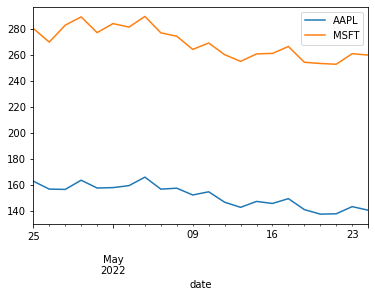

In [24]:
dataf[dataf['ticker']=="AAPL"].set_index("date")['Adj Close'].plot()
dataf[dataf['ticker']=="MSFT"].set_index("date")['Adj Close'].plot()
plt.legend(['AAPL', 'MSFT']);

In [25]:
pdr.remove_base_directory()

⚠ Deleting directory for 'PandasDataReader' ⚠
Path: 
'/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/pandas_datareader_test'

## 5. FinnhubDownloader

[Finnhub](https://finnhub.io) is a professional RESTFul stock API. Note that this a paid service. You will need to pass a Finnhub key (string) to use this downloader.

WARNING: Note that Finnhub has its own ticker format. You will need to make your own mapping from this format to for example Bloomberg tickers. See [documentation for ticker symbol conventions](https://finnhub.io/docs/api/stock-symbols).

In [26]:
# export
class FinnhubDownloader(BaseDownloader):
    """
    Download financial data from Finnhub.

    :param directory_path: Base folder to download files to. \n
    :param key: Valid Finnhub client key. \n
    :param tickers: List of valid Finnhub tickers. \n
    :param frequency: Choose from [1, 5, 15, 30, 60, D, W, M]. \n
    Daily data by default.
    """
    def __init__(self,
                 directory_path: str,
                 key: str,
                 tickers: list,
                 frequency: str = "D"):
        super().__init__(directory_path=directory_path)
        self.key = key
        self.tickers = tickers
        self.client = finnhub.Client(api_key=self.key)
        self.frequency = frequency
        self.current_time = dt.now()
        self.end_timestamp = int(self.current_time.timestamp())

    def download_inference_data(self):
        """ Download one year of data for defined tickers. """
        start = self.current_time - relativedelta(years=1)
        dataf = self.get_live_data(start=start)
        dataf.to_parquet(self._default_save_path(start=start,
                                                 end=self.current_time,
                                                 backend="finnhub"))

    def download_training_data(self, start: pd.Timestamp = None):
        """ Download full date length available. """
        start = start if start else pd.to_datetime(0)
        dataf = self.generate_full_dataf(start=start)
        dataf.to_parquet(self._default_save_path(start=start,
                                                 end=self.current_time,
                                                 backend="finnhub"))

    def get_live_data(self, start: pd.Timestamp) -> NumerFrame:
        """ Get NumerFrame containing one year of data. """
        dataf = self.generate_full_dataf(start=start)
        return NumerFrame(dataf)

    def generate_full_dataf(self, start: dt) -> pd.DataFrame:
        """ Collect all price data for list of Finnhub ticker symbols (without US). """
        price_datafs = []
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            tasks = [executor.submit(self.generate_stock_dataf, ticker, start) for ticker in self.tickers]
            for task in tqdm(concurrent.futures.as_completed(tasks),
                             total=len(self.tickers),
                             desc="Finnhub price data extraction"):
                price_datafs.append(task.result())
        return pd.concat(price_datafs)

    def generate_stock_dataf(self, ticker: str, start: dt) -> pd.DataFrame:
        """
        Generate Price DataFrame for a single ticker.
        ticker: Finnhub ticker symbol (without US).
        start: Datetime object denoting starting time.
        """
        candles = self.client.stock_candles(ticker,
                                            self.frequency,
                                            int(start.timestamp()),
                                            self.end_timestamp)
        try:
            stock_df = pd.DataFrame(candles)
        except:
            return pd.DataFrame()
        stock_df['ticker'] = ticker
        stock_df['date'] = pd.to_datetime(stock_df['t'], unit='s', origin='unix')
        stock_df = stock_df.drop(['s', 't'], axis=1)
        stock_df.columns = ['close', 'high', 'low', 'open', 'volume', 'ticker', 'date']
        return stock_df

In [27]:
#other
key = BaseDownloader._load_json("test_assets/keys.json")['finnhub_key'] # YOUR_FINNHUB_KEY_HERE
fhd = FinnhubDownloader(directory_path="finnhub_test", key=key, tickers=['AA', 'AAPL', 'MSFT', 'COIN'])

No existing directory found at 'finnhub_test'. Creating directory...

In [28]:
#other
fhd.download_inference_data()
fhd.download_training_data()

Finnhub price data extraction:   0%|          | 0/4 [00:00<?, ?it/s]

Finnhub price data extraction:   0%|          | 0/4 [00:00<?, ?it/s]

If no starting date is passed in `download_training_data` this downloader will take the earliest date available. That is why the starting date in the filename is the 1st Unix timestamp (January 1st 1970).

In [29]:
#other
today = dt.now().strftime("%Y%m%d")
df = pd.read_parquet(f"finnhub_test/finnhub_19700101_{today}.parquet")
df.head(2)

,close,high,low,open,volume,ticker,date
0,328.28,429.54,310.0000,381.0,81065746,COIN,2021-04-14
1,322.75,349.20,317.2701,348.9,39777858,COIN,2021-04-15


Live data with a custom starting date can be retrieved as a `NumerFrame` directly with `get_live_data`.

In [30]:
#other
live_dataf = fhd.get_live_data(start=pd.Timestamp(year=2021, month=1, day=1))
live_dataf.head(2)

Finnhub price data extraction:   0%|          | 0/4 [00:00<?, ?it/s]

,close,high,low,open,volume,ticker,date
0,217.69,223.00,214.81,222.53,37130139,MSFT,2021-01-04
1,217.90,218.52,215.70,217.26,23822953,MSFT,2021-01-05


In [31]:
#other
fhd.remove_base_directory()

⚠ Deleting directory for 'FinnhubDownloader' ⚠
Path: '/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/finnhub_test'

## 6. EODDownloader

[EOD Historical data](https://eodhistoricaldata.com/) is an affordable Financial data APIs that offers a large range of global stock tickers. Very convenient for Numerai Signals modeling. We will use a Python API build on top of EOD Historical data to download stock ticker data for training and inference.

In [32]:
# export
class EODDownloader(BaseDownloader):
    """
    Download data from EOD historical data. \n
    More info: https://eodhistoricaldata.com/

    :param directory_path: Base folder to download files to. \n
    :param key: Valid EOD client key. \n
    :param tickers: List of valid EOD tickers (Bloomberg ticker format). \n
    :param frequency: Choose from [d, w, m]. \n
    Daily data by default.
    """
    def __init__(self,
                 directory_path: str,
                 key: str,
                 tickers: list,
                 frequency: str = "d"):
        super().__init__(directory_path=directory_path)
        self.key = key
        self.tickers = tickers
        self.client = EodHistoricalData(self.key)
        self.frequency = frequency
        self.current_time = dt.now()
        self.end_date = self.current_time.strftime("%Y-%m-%d")

    def download_inference_data(self):
        """ Download one year of data for defined tickers. """
        start = (pd.Timestamp(self.current_time) - relativedelta(years=1)).strftime("%Y-%m-%d")
        dataf = self.get_live_data(start=start)
        dataf.to_parquet(self._default_save_path(start=pd.Timestamp(start),
                                                 end=pd.Timestamp(self.end_date),
                                                 backend="eod"))

    def download_training_data(self, start: str = None):
        """
        Download full date length available.
        start: Starting data in %Y-%m-%d format.
        """
        start = start if start else "1970-01-01"
        dataf = self.generate_full_dataf(start=start)
        dataf.to_parquet(self._default_save_path(start=pd.Timestamp(start),
                                                 end=pd.Timestamp(self.end_date),
                                                 backend="eod"))

    def get_live_data(self, start: str) -> NumerFrame:
        """
        Get NumerFrame containing one year of data.
        start: Starting data in %Y-%m-%d format.
        """
        dataf = self.generate_full_dataf(start=start)
        return NumerFrame(dataf)

    def generate_full_dataf(self, start: str) -> pd.DataFrame:
        """
        Collect all price data for list of EOD ticker symbols (Bloomberg tickers).
        start: Starting data in %Y-%m-%d format.
        """
        price_datafs = []
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            tasks = [executor.submit(self.generate_stock_dataf, ticker, start) for ticker in self.tickers]
            for task in tqdm(concurrent.futures.as_completed(tasks),
                             total=len(self.tickers),
                             desc="EOD price data extraction"):
                price_datafs.append(task.result())
        return pd.concat(price_datafs)

    def generate_stock_dataf(self, ticker: str, start: str) -> pd.DataFrame:
        """
        Generate Price DataFrame for a single ticker.
        ticker: EOD ticker symbol (Bloomberg tickers).
        For example, Apple stock = AAPL.US.
        start: Starting data in %Y-%m-%d format.
        """
        resp = self.client.get_prices_eod(ticker, period=self.frequency,
                                          from_=start, to=self.end_date)
        try:
            stock_df = pd.DataFrame(resp).set_index('date')
        except:
            return pd.DataFrame()
        stock_df['ticker'] = ticker
        return stock_df

In [33]:
#other
key = BaseDownloader._load_json("test_assets/keys.json")['eod_key'] # YOUR_EOD_KEY_HERE
eodd = EODDownloader(directory_path="eod_test", key=key, tickers=['AAPL.US', 'MSFT.US', 'COIN.US'])

If no starting date is passed in `download_training_data` this downloader will take the earliest date available. That is why the starting date in the filename is the 1st Unix timestamp (January 1st 1970).

In [34]:
#other
eodd.download_inference_data()
eodd.download_training_data()

EOD price data extraction:   0%|          | 0/3 [00:00<?, ?it/s]

EOD price data extraction:   0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
#other
today = dt.now().strftime("%Y%m%d")
df = pd.read_parquet(f"eod_test/eod_19700101_{today}.parquet")
df.head(2)

,open,high,low,close,adjusted_close,volume,ticker
date,,,,,,,
2021-04-09,381.0,381.0,381.0,381.0,250.0,0,COIN.US
2021-04-12,381.0,381.0,381.0,381.0,250.0,0,COIN.US


Live data with a custom starting date can be retrieved as a `NumerFrame` directly with `get_live_data`. The starting date can be either in `datetime`, `pd.Timestamp` or string format.

In [36]:
#other
live_dataf = fhd.get_live_data(start=pd.Timestamp(year=2021, month=1, day=1))
live_dataf.head(2)

Finnhub price data extraction:   0%|          | 0/4 [00:00<?, ?it/s]

,close,high,low,open,volume,ticker,date
0,328.28,429.54,310.0000,381.0,81065746,COIN,2021-04-14
1,322.75,349.20,317.2701,348.9,39777858,COIN,2021-04-15


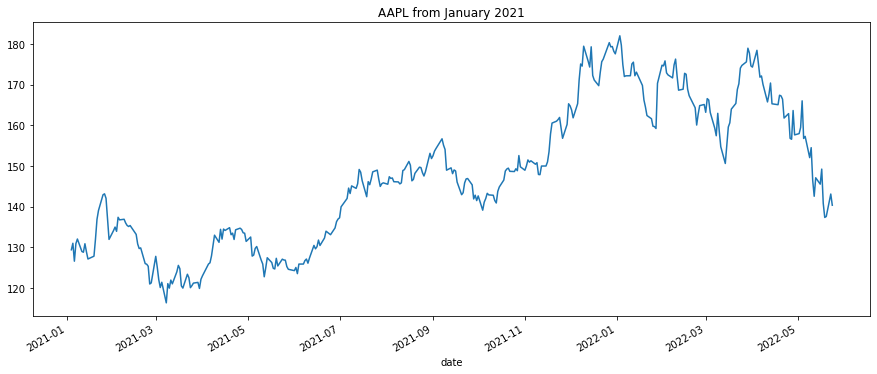

In [37]:
#other
live_dataf[live_dataf['ticker']=="AAPL"].set_index("date")['close'].plot(figsize=(15, 6), title="AAPL from January 2021");

In [38]:
#other
eodd.remove_base_directory()

⚠ Deleting directory for 'EODDownloader' ⚠
Path: '/Users/clepelaars/Desktop/crowdcent/repositories/numerai-blocks/nbs/eod_test'

## 7. Custom Downloader

We invite the Numerai Community to implement new downloaders for this project using interesting APIs.

These are especially important for creating innovative Numerai Signals models.

A new Downloader can be created by inheriting from `BaseDownloader`. You should implement methods for `.download_inference_data` and `.download_training_data` so every downloader has a common interface. Below you will find a template for a new downloader.

In [39]:
# export
class AwesomeCustomDownloader(BaseDownloader):
    """
    TEMPLATE -
    Download awesome financial data from who knows where.

    :param directory_path: Base folder to download files to.
    """
    def __init__(self, directory_path: str):
        super().__init__(directory_path=directory_path)

    def download_inference_data(self, *args, **kwargs):
        """ (minimal) weekly inference downloading here. """
        ...

    def download_training_data(self, *args, **kwargs):
        """ Training + validation dataset downloading here. """
        ...

------------------------------------------------------------

In [40]:
# hide
# Run this cell to sync all changes with library
from nbdev.export import notebook2script

notebook2script()

Converted 00_misc.ipynb.
Converted 01_download.ipynb.
Converted 02_numerframe.ipynb.
Converted 03_preprocessing.ipynb.
Converted 04_model.ipynb.
Converted 05_postprocessing.ipynb.
Converted 06_modelpipeline.ipynb.
Converted 07_evaluation.ipynb.
Converted 08_key.ipynb.
Converted 09_submission.ipynb.
Converted 10_staking.ipynb.
Converted index.ipynb.
